In [1]:
import os
import tqdm
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import make_column_selector
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

import joblib

from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.preprocessing import StandardScaler
import catboost
from sklearn.metrics import roc_auc_score
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt

In [2]:
import torch
from torch import nn
from torcheval.metrics import BinaryAUROC
from torch.nn import functional as F

from torch.utils.data import TensorDataset, DataLoader

import sklearn
from sklearn.ensemble import BaggingClassifier
from torch.optim import Adam, Adadelta, RMSprop

from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau, LinearLR, MultiStepLR

## Reading and viewing data

In [3]:
def read_parquet_dataset_from_local(path_to_dataset: str, start_from: int = 0,
                                     num_parts_to_read: int = 2, columns=None, verbose=False) -> pd.DataFrame:
    res = []
    dataset_paths = sorted([os.path.join(path_to_dataset, filename) for filename in os.listdir(path_to_dataset)
                              if filename.startswith('train')])
    print(dataset_paths)

    start_from = max(0, start_from)
    chunks = dataset_paths[start_from: start_from + num_parts_to_read]
    if verbose:
        print('Reading chunks:\n')
        for chunk in chunks:
            print(chunk)
    for chunk_path in tqdm.tqdm_notebook(chunks, desc="Reading dataset with pandas"):
        print('chunk_path', chunk_path)
        chunk = pd.read_parquet(chunk_path,columns=columns)
        res.append(chunk)

    return pd.concat(res).reset_index(drop=True)


def create_dataset(path):
    for i, elem in enumerate(['df_'+str(a) for a in range(0, 12)]):
        elem = read_parquet_dataset_from_local(path, i, 1)
        if i==0:
            df = elem.copy()
        else:
            df = pd.concat([df, elem], ignore_index=True, axis=0)
        del elem
    return df

In [5]:
path = 'train_data/'
df = create_dataset(path)

['train_data/train_data_0.pq', 'train_data/train_data_1.pq', 'train_data/train_data_10.pq', 'train_data/train_data_11.pq', 'train_data/train_data_2.pq', 'train_data/train_data_3.pq', 'train_data/train_data_4.pq', 'train_data/train_data_5.pq', 'train_data/train_data_6.pq', 'train_data/train_data_7.pq', 'train_data/train_data_8.pq', 'train_data/train_data_9.pq']


Reading dataset with pandas:   0%|          | 0/1 [00:00<?, ?it/s]

chunk_path train_data/train_data_0.pq
['train_data/train_data_0.pq', 'train_data/train_data_1.pq', 'train_data/train_data_10.pq', 'train_data/train_data_11.pq', 'train_data/train_data_2.pq', 'train_data/train_data_3.pq', 'train_data/train_data_4.pq', 'train_data/train_data_5.pq', 'train_data/train_data_6.pq', 'train_data/train_data_7.pq', 'train_data/train_data_8.pq', 'train_data/train_data_9.pq']


Reading dataset with pandas:   0%|          | 0/1 [00:00<?, ?it/s]

chunk_path train_data/train_data_1.pq
['train_data/train_data_0.pq', 'train_data/train_data_1.pq', 'train_data/train_data_10.pq', 'train_data/train_data_11.pq', 'train_data/train_data_2.pq', 'train_data/train_data_3.pq', 'train_data/train_data_4.pq', 'train_data/train_data_5.pq', 'train_data/train_data_6.pq', 'train_data/train_data_7.pq', 'train_data/train_data_8.pq', 'train_data/train_data_9.pq']


Reading dataset with pandas:   0%|          | 0/1 [00:00<?, ?it/s]

chunk_path train_data/train_data_10.pq
['train_data/train_data_0.pq', 'train_data/train_data_1.pq', 'train_data/train_data_10.pq', 'train_data/train_data_11.pq', 'train_data/train_data_2.pq', 'train_data/train_data_3.pq', 'train_data/train_data_4.pq', 'train_data/train_data_5.pq', 'train_data/train_data_6.pq', 'train_data/train_data_7.pq', 'train_data/train_data_8.pq', 'train_data/train_data_9.pq']


Reading dataset with pandas:   0%|          | 0/1 [00:00<?, ?it/s]

chunk_path train_data/train_data_11.pq
['train_data/train_data_0.pq', 'train_data/train_data_1.pq', 'train_data/train_data_10.pq', 'train_data/train_data_11.pq', 'train_data/train_data_2.pq', 'train_data/train_data_3.pq', 'train_data/train_data_4.pq', 'train_data/train_data_5.pq', 'train_data/train_data_6.pq', 'train_data/train_data_7.pq', 'train_data/train_data_8.pq', 'train_data/train_data_9.pq']


Reading dataset with pandas:   0%|          | 0/1 [00:00<?, ?it/s]

chunk_path train_data/train_data_2.pq
['train_data/train_data_0.pq', 'train_data/train_data_1.pq', 'train_data/train_data_10.pq', 'train_data/train_data_11.pq', 'train_data/train_data_2.pq', 'train_data/train_data_3.pq', 'train_data/train_data_4.pq', 'train_data/train_data_5.pq', 'train_data/train_data_6.pq', 'train_data/train_data_7.pq', 'train_data/train_data_8.pq', 'train_data/train_data_9.pq']


Reading dataset with pandas:   0%|          | 0/1 [00:00<?, ?it/s]

chunk_path train_data/train_data_3.pq
['train_data/train_data_0.pq', 'train_data/train_data_1.pq', 'train_data/train_data_10.pq', 'train_data/train_data_11.pq', 'train_data/train_data_2.pq', 'train_data/train_data_3.pq', 'train_data/train_data_4.pq', 'train_data/train_data_5.pq', 'train_data/train_data_6.pq', 'train_data/train_data_7.pq', 'train_data/train_data_8.pq', 'train_data/train_data_9.pq']


Reading dataset with pandas:   0%|          | 0/1 [00:00<?, ?it/s]

chunk_path train_data/train_data_4.pq
['train_data/train_data_0.pq', 'train_data/train_data_1.pq', 'train_data/train_data_10.pq', 'train_data/train_data_11.pq', 'train_data/train_data_2.pq', 'train_data/train_data_3.pq', 'train_data/train_data_4.pq', 'train_data/train_data_5.pq', 'train_data/train_data_6.pq', 'train_data/train_data_7.pq', 'train_data/train_data_8.pq', 'train_data/train_data_9.pq']


Reading dataset with pandas:   0%|          | 0/1 [00:00<?, ?it/s]

chunk_path train_data/train_data_5.pq
['train_data/train_data_0.pq', 'train_data/train_data_1.pq', 'train_data/train_data_10.pq', 'train_data/train_data_11.pq', 'train_data/train_data_2.pq', 'train_data/train_data_3.pq', 'train_data/train_data_4.pq', 'train_data/train_data_5.pq', 'train_data/train_data_6.pq', 'train_data/train_data_7.pq', 'train_data/train_data_8.pq', 'train_data/train_data_9.pq']


Reading dataset with pandas:   0%|          | 0/1 [00:00<?, ?it/s]

chunk_path train_data/train_data_6.pq
['train_data/train_data_0.pq', 'train_data/train_data_1.pq', 'train_data/train_data_10.pq', 'train_data/train_data_11.pq', 'train_data/train_data_2.pq', 'train_data/train_data_3.pq', 'train_data/train_data_4.pq', 'train_data/train_data_5.pq', 'train_data/train_data_6.pq', 'train_data/train_data_7.pq', 'train_data/train_data_8.pq', 'train_data/train_data_9.pq']


Reading dataset with pandas:   0%|          | 0/1 [00:00<?, ?it/s]

chunk_path train_data/train_data_7.pq
['train_data/train_data_0.pq', 'train_data/train_data_1.pq', 'train_data/train_data_10.pq', 'train_data/train_data_11.pq', 'train_data/train_data_2.pq', 'train_data/train_data_3.pq', 'train_data/train_data_4.pq', 'train_data/train_data_5.pq', 'train_data/train_data_6.pq', 'train_data/train_data_7.pq', 'train_data/train_data_8.pq', 'train_data/train_data_9.pq']


Reading dataset with pandas:   0%|          | 0/1 [00:00<?, ?it/s]

chunk_path train_data/train_data_8.pq
['train_data/train_data_0.pq', 'train_data/train_data_1.pq', 'train_data/train_data_10.pq', 'train_data/train_data_11.pq', 'train_data/train_data_2.pq', 'train_data/train_data_3.pq', 'train_data/train_data_4.pq', 'train_data/train_data_5.pq', 'train_data/train_data_6.pq', 'train_data/train_data_7.pq', 'train_data/train_data_8.pq', 'train_data/train_data_9.pq']


Reading dataset with pandas:   0%|          | 0/1 [00:00<?, ?it/s]

chunk_path train_data/train_data_9.pq


In [6]:
df.head()

,id,rn,pre_since_opened,pre_since_confirmed,pre_pterm,pre_fterm,pre_till_pclose,pre_till_fclose,pre_loans_credit_limit,pre_loans_next_pay_summ,...,enc_paym_21,enc_paym_22,enc_paym_23,enc_paym_24,enc_loans_account_holder_type,enc_loans_credit_status,enc_loans_credit_type,enc_loans_account_cur,pclose_flag,fclose_flag
0,0,1,18,9,2,3,16,10,11,3,...,3,3,3,4,1,3,4,1,0,0
1,0,2,18,9,14,14,12,12,0,3,...,0,0,0,4,1,3,4,1,0,0
2,0,3,18,9,4,8,1,11,11,0,...,0,0,0,4,1,2,3,1,1,1
3,0,4,4,1,9,12,16,7,12,2,...,3,3,3,4,1,3,1,1,0,0
4,0,5,5,12,15,2,11,12,10,2,...,3,3,3,4,1,3,4,1,0,0


In [7]:
df.shape

(26162717, 61)

In [8]:
targets = pd.read_csv('train_target.csv')
targets

,id,flag
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0
...,...,...
2999995,2999995,0
2999996,2999996,0
2999997,2999997,0
2999998,2999998,0


## Data preprocessing

In [9]:
columns_to_drop = ['pre_since_opened', 'pre_since_confirmed', 'pre_fterm', 'pre_till_pclose', 
                   'pre_till_fclose', 'pre_loans_outstanding', 'pre_loans_total_overdue',
                   'pre_loans_max_overdue_sum', 'pre_loans90', #'is_zero_loans90', 
                   'is_zero_util', 'is_zero_over2limit', 'is_zero_maxover2limit', 
                   'enc_paym_0', 'enc_paym_1', 'enc_paym_2', 'enc_paym_3', 'enc_paym_4', 'enc_paym_5', 
                   'enc_paym_6', 'enc_paym_7', 'enc_paym_8', 'enc_paym_9', 'enc_paym_10', 'enc_paym_11', 
                   'enc_paym_12', 'enc_paym_13', 'enc_paym_14', 'enc_paym_15', 'enc_paym_16', 'enc_paym_17', 
                   'enc_paym_18', 'enc_paym_19', 'enc_paym_20','enc_paym_21']
df.drop(columns_to_drop, axis=1, inplace=True)

In [10]:
df.isna().sum()

id                               0
rn                               0
pre_pterm                        0
pre_loans_credit_limit           0
pre_loans_next_pay_summ          0
pre_loans_credit_cost_rate       0
pre_loans5                       0
pre_loans530                     0
pre_loans3060                    0
pre_loans6090                    0
is_zero_loans5                   0
is_zero_loans530                 0
is_zero_loans3060                0
is_zero_loans6090                0
is_zero_loans90                  0
pre_util                         0
pre_over2limit                   0
pre_maxover2limit                0
enc_paym_22                      0
enc_paym_23                      0
enc_paym_24                      0
enc_loans_account_holder_type    0
enc_loans_credit_status          0
enc_loans_credit_type            0
enc_loans_account_cur            0
pclose_flag                      0
fclose_flag                      0
dtype: int64

In [11]:
cat_columns = ['pre_pterm', 'pre_loans_credit_limit',  'pre_loans_next_pay_summ', 'pre_loans_credit_cost_rate',
              'pre_loans5', 'pre_loans530', 'pre_loans3060', 'pre_loans6090', 'pre_util', 'pre_over2limit', 'is_zero_loans90', 
               'pre_maxover2limit', 'enc_paym_22', 'enc_paym_23', 'enc_paym_24', 'enc_loans_account_holder_type',
               'enc_loans_credit_status', 'enc_loans_credit_type', 'enc_loans_account_cur']

ohe = OneHotEncoder(sparse_output=False, drop='first', handle_unknown='ignore', dtype='int8')
df[ohe.get_feature_names_out()] = ohe.fit_transform(df[cat_columns])
df.drop(columns=cat_columns, inplace=True)

In [12]:
df.head()

,id,rn,is_zero_loans5,is_zero_loans530,is_zero_loans3060,is_zero_loans6090,pclose_flag,fclose_flag,pre_pterm_1,pre_pterm_2,...,enc_loans_credit_type_1,enc_loans_credit_type_2,enc_loans_credit_type_3,enc_loans_credit_type_4,enc_loans_credit_type_5,enc_loans_credit_type_6,enc_loans_credit_type_7,enc_loans_account_cur_1,enc_loans_account_cur_2,enc_loans_account_cur_3
0,0,1,1,1,1,1,0,0,0,1,...,0,0,0,1,0,0,0,1,0,0
1,0,2,1,1,1,1,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
2,0,3,1,1,1,1,1,1,0,0,...,0,0,1,0,0,0,0,1,0,0
3,0,4,0,1,1,1,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0
4,0,5,1,1,1,1,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0


In [13]:
df.shape

(26162717, 196)

In [14]:
df_1 = df.iloc[:, :2].copy().groupby(['id']).max()
df_1.columns = ['max_rn']
df = df.groupby(['id']).sum()

In [15]:
df.head()

,rn,is_zero_loans5,is_zero_loans530,is_zero_loans3060,is_zero_loans6090,pclose_flag,fclose_flag,pre_pterm_1,pre_pterm_2,pre_pterm_3,...,enc_loans_credit_type_1,enc_loans_credit_type_2,enc_loans_credit_type_3,enc_loans_credit_type_4,enc_loans_credit_type_5,enc_loans_credit_type_6,enc_loans_credit_type_7,enc_loans_account_cur_1,enc_loans_account_cur_2,enc_loans_account_cur_3
id,,,,,,,,,,,,,,,,,,,,,
0,55,9,10,10,10,1,2,1,3,0,...,1,0,2,7,0,0,0,10,0,0
1,105,12,10,12,12,1,2,3,1,0,...,3,0,3,8,0,0,0,14,0,0
2,6,3,2,2,2,2,2,0,0,0,...,0,0,2,1,0,0,0,3,0,0
3,120,15,15,15,15,5,6,1,1,0,...,1,0,4,9,1,0,0,15,0,0
4,1,1,1,1,1,1,1,0,0,0,...,0,0,1,0,0,0,0,1,0,0


In [16]:
df.merge(df_1, how='left', on='id').drop(columns='rn')

,is_zero_loans5,is_zero_loans530,is_zero_loans3060,is_zero_loans6090,pclose_flag,fclose_flag,pre_pterm_1,pre_pterm_2,pre_pterm_3,pre_pterm_4,...,enc_loans_credit_type_2,enc_loans_credit_type_3,enc_loans_credit_type_4,enc_loans_credit_type_5,enc_loans_credit_type_6,enc_loans_credit_type_7,enc_loans_account_cur_1,enc_loans_account_cur_2,enc_loans_account_cur_3,max_rn
id,,,,,,,,,,,,,,,,,,,,,
0,9,10,10,10,1,2,1,3,0,1,...,0,2,7,0,0,0,10,0,0,10
1,12,10,12,12,1,2,3,1,0,1,...,0,3,8,0,0,0,14,0,0,14
2,3,2,2,2,2,2,0,0,0,2,...,0,2,1,0,0,0,3,0,0,3
3,15,15,15,15,5,6,1,1,0,5,...,0,4,9,1,0,0,15,0,0,15
4,1,1,1,1,1,1,0,0,0,1,...,0,1,0,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2999995,9,5,11,11,2,5,0,2,0,2,...,0,4,6,0,0,1,11,0,0,11
2999996,12,13,12,13,5,4,0,0,0,5,...,0,4,8,0,0,1,13,0,0,13
2999997,9,7,10,10,1,1,0,1,0,1,...,0,3,7,0,0,0,10,0,0,10


In [17]:
df.loc[:, 'target'] = targets.loc[:, 'flag']

In [21]:
df[df.duplicated()]

,rn,is_zero_loans5,is_zero_loans530,is_zero_loans3060,is_zero_loans6090,pclose_flag,fclose_flag,pre_pterm_1,pre_pterm_2,pre_pterm_3,...,enc_loans_credit_type_2,enc_loans_credit_type_3,enc_loans_credit_type_4,enc_loans_credit_type_5,enc_loans_credit_type_6,enc_loans_credit_type_7,enc_loans_account_cur_1,enc_loans_account_cur_2,enc_loans_account_cur_3,target
id,,,,,,,,,,,,,,,,,,,,,
488,1,1,1,1,1,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
1327,1,1,1,1,1,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
2165,1,1,1,1,1,1,1,0,0,0,...,0,1,0,0,0,0,1,0,0,0
2275,1,1,1,1,1,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
3974,1,1,1,1,1,1,1,0,0,0,...,0,1,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2999887,1,1,1,1,1,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
2999891,1,1,1,1,1,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
2999902,1,1,1,1,1,1,1,0,0,0,...,0,0,1,0,0,0,1,0,0,0


In [18]:
df.drop_duplicates(inplace=True)

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2859170 entries, 0 to 2999999
Columns: 196 entries, rn to target
dtypes: int64(8), int8(188)
memory usage: 708.9 MB


In [20]:
int_64_cols  = df.select_dtypes('int64').columns
df[int_64_cols] = df[int_64_cols].astype('int8')

In [21]:
df['target'].value_counts()[1]/df['target'].value_counts()[0]
#strong class imbalance

0.03740344539696373

# Modeling

In [22]:
X_train, X_test, y_train, y_test = train_test_split(df[df.columns[:-1]], df['target'], stratify=df['target'], train_size=0.7)

In [23]:
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)

## LogisticRegression

In [24]:
log = LogisticRegression()
log.fit(X_train_sc, y_train)
print('train: ', roc_auc_score(y_train, log.predict_proba(X_train_sc)[:,1]))
print('test: ', roc_auc_score(y_test, log.predict_proba(X_test_sc)[:,1]))

train:  0.7232753423140577
test:  0.721330067265804


#### +SMOTE

In [25]:
from imblearn.over_sampling import SMOTE
os = SMOTE(k_neighbors=2)
X_train_2, y_train_2 = os.fit_resample(X_train_sc, y_train)

log.fit(X_train_2, y_train_2)
print('train: ', roc_auc_score(y_train_2, log.predict_proba(X_train_2)[:,1]))
print('test: ', roc_auc_score(y_test, log.predict_proba(X_test_sc)[:,1]))

train:  0.7432296527381334
test:  0.7173899047440927


In [26]:
#score has not improved, model is a little overfitted

#### Grid

In [19]:
params_log = {'C': [10, 1, 0.1, 0.01],
             'class_weight': ['balanced', None]}
grid_log = GridSearchCV(log, param_grid=params_log, cv=2, scoring='roc_auc', verbose=1, n_jobs=-1)
grid_log.fit(X_train_sc, y_train)

Fitting 2 folds for each of 8 candidates, totalling 16 fits


C:\Users\bogho\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


GridSearchCV(cv=2, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [10, 1, 0.1, 0.01],
                         'class_weight': ['balanced', None]},
             scoring='roc_auc', verbose=1)

In [20]:
grid_log.best_score_

0.7256235829729973

In [21]:
grid_log_model = grid_log.best_estimator_
grid_log_model.fit(X_train_sc, y_train)
print('train: ', roc_auc_score(y_train, grid_log_model.predict_proba(X_train_sc)[:,1]))
print('test: ', roc_auc_score(y_test, grid_log_model.predict_proba(X_test_sc)[:,1]))

C:\Users\bogho\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


train:  0.7267444233617524
test:  0.7245628731277359


## Catboost

In [43]:
boosting_model = catboost.CatBoostClassifier(n_estimators=200, learning_rate=0.3, eval_metric='AUC',
                                             early_stopping_rounds=20, verbose=20, random_seed=42)
boosting_model.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=20, plot=True)

print('train: ', roc_auc_score(y_train, boosting_model.predict_proba(X_train)[:, 1]))
print('test: ', roc_auc_score(y_test, boosting_model.predict_proba(X_test)[:, 1]))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.5136239	best: 0.5136239 (0)	total: 316ms	remaining: 1m 2s
20:	test: 0.7268109	best: 0.7268109 (20)	total: 11s	remaining: 1m 34s
40:	test: 0.7377880	best: 0.7377880 (40)	total: 21.7s	remaining: 1m 24s
60:	test: 0.7429433	best: 0.7429433 (60)	total: 32.5s	remaining: 1m 14s
80:	test: 0.7452983	best: 0.7452983 (80)	total: 42.8s	remaining: 1m 2s
100:	test: 0.7465679	best: 0.7465679 (100)	total: 52.6s	remaining: 51.6s
120:	test: 0.7474535	best: 0.7474535 (120)	total: 1m 2s	remaining: 40.7s
140:	test: 0.7483265	best: 0.7483265 (140)	total: 1m 11s	remaining: 30.1s
160:	test: 0.7487045	best: 0.7487069 (158)	total: 1m 21s	remaining: 19.7s
180:	test: 0.7490716	best: 0.7490716 (180)	total: 1m 30s	remaining: 9.5s
199:	test: 0.7493597	best: 0.7493773 (197)	total: 1m 40s	remaining: 0us

bestTest = 0.7493772559
bestIteration = 197

Shrink model to first 198 iterations.
train:  0.7578590434922184
test:  0.7493772559287459


### Grid

In [107]:
boosting_model = catboost.CatBoostClassifier(n_estimators=200, learning_rate=0.3, eval_metric='AUC',
                                             early_stopping_rounds=20, verbose=20, random_seed=42)

params = {'depth': np.arange(4, 8, 1), 'learning_rate': np.arange(0.1, 0.5, 0.1), 'min_data_in_leaf': np.arange(3, 5, 1)}

boosting_model.grid_search(params, X_train, y_train, cv=3, search_by_train_test_split=True, calc_cv_statistics=True,
                           plot=True, refit=True, stratified=True) 

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.5053388	best: 0.5053388 (0)	total: 177ms	remaining: 35.2s
20:	test: 0.6941101	best: 0.6941101 (20)	total: 4.86s	remaining: 41.4s
40:	test: 0.7078560	best: 0.7078560 (40)	total: 10.6s	remaining: 41.1s
60:	test: 0.7169596	best: 0.7169596 (60)	total: 16.5s	remaining: 37.5s
80:	test: 0.7235050	best: 0.7235050 (80)	total: 22.7s	remaining: 33.3s
100:	test: 0.7275101	best: 0.7275101 (100)	total: 29.3s	remaining: 28.7s
120:	test: 0.7309723	best: 0.7309723 (120)	total: 36.3s	remaining: 23.7s
140:	test: 0.7341186	best: 0.7341186 (140)	total: 43.2s	remaining: 18.1s
160:	test: 0.7363189	best: 0.7363189 (160)	total: 49.5s	remaining: 12s
180:	test: 0.7382495	best: 0.7382495 (180)	total: 56s	remaining: 5.88s
199:	test: 0.7393601	best: 0.7393601 (199)	total: 1m 2s	remaining: 0us

bestTest = 0.7393601424
bestIteration = 199

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
0:	loss: 0.7393601	best: 0.7393601 

{'params': {'min_data_in_leaf': 3,
  'depth': 7,
  'learning_rate': 0.30000000000000004},
 'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30,
               31,
               32,
               33,
               34,
               35,
               36,
               37,
               38,
               39,
               40,
               41,
               42,
               43,
               44,
               45,

20:	test: 0.6941101	best: 0.6941101 (20)	total: 5.75s	remaining: 49s
40:	test: 0.7078560	best: 0.7078560 (40)	total: 11.6s	remaining: 45.1s
60:	test: 0.7169596	best: 0.7169596 (60)	total: 17.3s	remaining: 39.5s
80:	test: 0.7235050	best: 0.7235050 (80)	total: 23.2s	remaining: 34s
100:	test: 0.7275101	best: 0.7275101 (100)	total: 29s	remaining: 28.4s
120:	test: 0.7309723	best: 0.7309723 (120)	total: 34.8s	remaining: 22.7s
140:	test: 0.7341186	best: 0.7341186 (140)	total: 41.1s	remaining: 17.2s
160:	test: 0.7363189	best: 0.7363189 (160)	total: 46.9s	remaining: 11.4s
180:	test: 0.7382495	best: 0.7382495 (180)	total: 53s	remaining: 5.56s
199:	test: 0.7393601	best: 0.7393601 (199)	total: 59s	remaining: 0us

bestTest = 0.7393601424
bestIteration = 199

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
16:	loss: 0.7393601	best: 0.7501471 (14)	total: 19m 40s	remaining: 17m 21s
0:	test: 0.5053388	best: 0.5053388 

0:	test: 0.5579289	best: 0.5579289 (0)	total: 237ms	remaining: 47.1s
20:	test: 0.7034370	best: 0.7034370 (20)	total: 6.84s	remaining: 58.3s
40:	test: 0.7186187	best: 0.7186187 (40)	total: 14.4s	remaining: 56s
60:	test: 0.7279600	best: 0.7279600 (60)	total: 22.1s	remaining: 50.5s
80:	test: 0.7331008	best: 0.7331008 (80)	total: 32.2s	remaining: 47.3s
100:	test: 0.7367479	best: 0.7367479 (100)	total: 40.7s	remaining: 39.9s
120:	test: 0.7396022	best: 0.7396022 (120)	total: 48.3s	remaining: 31.6s
140:	test: 0.7414634	best: 0.7414634 (140)	total: 56.3s	remaining: 23.6s
160:	test: 0.7429885	best: 0.7429885 (160)	total: 1m 3s	remaining: 15.5s
180:	test: 0.7442519	best: 0.7442519 (180)	total: 1m 11s	remaining: 7.5s
199:	test: 0.7451130	best: 0.7451130 (199)	total: 1m 18s	remaining: 0us

bestTest = 0.7451130219
bestIteration = 199

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
24:	loss: 0.7451130	best: 0.7501

0:	test: 0.5466240	best: 0.5466240 (0)	total: 308ms	remaining: 1m 1s
20:	test: 0.7280062	best: 0.7280062 (20)	total: 7.44s	remaining: 1m 3s
40:	test: 0.7372597	best: 0.7372597 (40)	total: 14.3s	remaining: 55.6s
60:	test: 0.7412573	best: 0.7412573 (60)	total: 20.9s	remaining: 47.5s
80:	test: 0.7433852	best: 0.7433852 (80)	total: 27.2s	remaining: 40s
100:	test: 0.7441864	best: 0.7441900 (99)	total: 33.5s	remaining: 32.8s
120:	test: 0.7447557	best: 0.7448117 (117)	total: 39.3s	remaining: 25.7s
140:	test: 0.7449382	best: 0.7450386 (133)	total: 45.3s	remaining: 18.9s
160:	test: 0.7453059	best: 0.7453059 (160)	total: 51.4s	remaining: 12.5s
180:	test: 0.7456439	best: 0.7456526 (176)	total: 57.5s	remaining: 6.03s
199:	test: 0.7458717	best: 0.7458717 (199)	total: 1m 2s	remaining: 0us

bestTest = 0.745871653
bestIteration = 199

Training on fold [1/3]
0:	test: 0.5030965	best: 0.5030965 (0)	total: 208ms	remaining: 41.4s
20:	test: 0.7269786	best: 0.7269786 (20)	total: 6.96s	remaining: 59.3s
40:	te

{'params': {'min_data_in_leaf': 3,
  'depth': 7,
  'learning_rate': 0.30000000000000004},
 'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30,
               31,
               32,
               33,
               34,
               35,
               36,
               37,
               38,
               39,
               40,
               41,
               42,
               43,
               44,
               45,

In [135]:
best_params = boosting_model.get_all_params()
best_params

{'nan_mode': 'Min',
 'eval_metric': 'AUC',
 'iterations': 200,
 'sampling_frequency': 'PerTree',
 'leaf_estimation_method': 'Newton',
 'od_pval': 0,
 'random_score_type': 'NormalWithModelSizeDecrease',
 'grow_policy': 'SymmetricTree',
 'penalties_coefficient': 1,
 'boosting_type': 'Plain',
 'model_shrink_mode': 'Constant',
 'feature_border_type': 'GreedyLogSum',
 'bayesian_matrix_reg': 0.10000000149011612,
 'eval_fraction': 0,
 'force_unit_auto_pair_weights': False,
 'l2_leaf_reg': 3,
 'random_strength': 1,
 'od_type': 'Iter',
 'rsm': 1,
 'boost_from_average': False,
 'model_size_reg': 0.5,
 'pool_metainfo_options': {'tags': {}},
 'subsample': 0.800000011920929,
 'use_best_model': True,
 'od_wait': 20,
 'class_names': [0, 1],
 'random_seed': 42,
 'depth': 7,
 'posterior_sampling': False,
 'border_count': 254,
 'classes_count': 0,
 'auto_class_weights': 'None',
 'sparse_features_conflict_fraction': 0,
 'leaf_estimation_backtracking': 'AnyImprovement',
 'best_model_min_trees': 1,
 'model

In [115]:
boosting_model.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=20, plot=True)

print('train: ', roc_auc_score(y_train, boosting_model.predict_proba(X_train)[:, 1]))
print('test: ', roc_auc_score(y_test, boosting_model.predict_proba(X_test)[:, 1]))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.5276175	best: 0.5276175 (0)	total: 305ms	remaining: 1m
20:	test: 0.7306887	best: 0.7306887 (20)	total: 8.18s	remaining: 1m 9s
40:	test: 0.7397627	best: 0.7397627 (40)	total: 17s	remaining: 1m 6s
60:	test: 0.7437593	best: 0.7437593 (60)	total: 25.5s	remaining: 58.1s
80:	test: 0.7457337	best: 0.7457337 (80)	total: 33.7s	remaining: 49.5s
100:	test: 0.7474146	best: 0.7474146 (100)	total: 41.7s	remaining: 40.8s
120:	test: 0.7485615	best: 0.7485615 (120)	total: 49.8s	remaining: 32.5s
140:	test: 0.7490383	best: 0.7490383 (140)	total: 58.6s	remaining: 24.5s
160:	test: 0.7495891	best: 0.7495891 (160)	total: 1m 7s	remaining: 16.3s
180:	test: 0.7499892	best: 0.7499892 (180)	total: 1m 16s	remaining: 8.08s
199:	test: 0.7503665	best: 0.7503665 (199)	total: 1m 26s	remaining: 0us

bestTest = 0.7503665149
bestIteration = 199

train:  0.7635428735697274
test:  0.7503665148902103


In [7]:
boosting_model.get_feature_importance(prettified=True)

,Feature Id,Importances
0,pre_util_3,8.154100
1,is_zero_loans530,7.547831
2,pre_loans_credit_limit_2,6.612090
3,pre_util_6,5.342999
4,enc_paym_22_3,4.650208
...,...,...
190,pre_loans3060_6,0.000000
191,pre_loans3060_9,0.000000
192,pre_loans6090_3,0.000000
193,pre_over2limit_18,0.000000


In [11]:
# removing unnecessary features
df_imp = pd.DataFrame(boosting_model.get_feature_importance(prettified=True))
new_cols = df_imp.loc[df_imp['Importances']>0]['Feature Id'].tolist()
X_train, X_test, y_train, y_test = train_test_split(df[new_cols], df['target'], stratify=df['target'], train_size=0.7)
X_train.shape

(2001418, 175)

In [12]:
boosting_model_2 = catboost.CatBoostClassifier(n_estimators=500, learning_rate=0.3, eval_metric='AUC',
                                             early_stopping_rounds=20, verbose=20, random_seed=42,
                                            depth=7, min_data_in_leaf=3)

boosting_model_2.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=50, plot=True)

print('train: ', roc_auc_score(y_train, boosting_model_2.predict_proba(X_train)[:, 1]))
print('test: ', roc_auc_score(y_test, boosting_model_2.predict_proba(X_test)[:, 1]))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.5947286	best: 0.5947286 (0)	total: 345ms	remaining: 2m 52s
50:	test: 0.7426050	best: 0.7426050 (50)	total: 21s	remaining: 3m 4s
100:	test: 0.7477287	best: 0.7477287 (100)	total: 40.5s	remaining: 2m 39s
150:	test: 0.7498418	best: 0.7498418 (150)	total: 1m	remaining: 2m 18s
200:	test: 0.7507420	best: 0.7507819 (198)	total: 1m 19s	remaining: 1m 58s
250:	test: 0.7513661	best: 0.7513809 (249)	total: 1m 38s	remaining: 1m 37s
300:	test: 0.7518082	best: 0.7518316 (299)	total: 1m 57s	remaining: 1m 17s
350:	test: 0.7521967	best: 0.7522053 (349)	total: 2m 17s	remaining: 58.4s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.7522874505
bestIteration = 357

Shrink model to first 358 iterations.
train:  0.7709935366016526
test:  0.7522874505188494


## Neural network

#### with Relu

In [23]:
from tqdm.auto import tqdm

X_train, X_test, y_train, y_test = train_test_split(df[df.columns[:-1]], df['target'], stratify=df['target'], train_size=0.7, random_state=1)

scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)

X_train_t =  torch.FloatTensor(X_train.values)
y_train_t =  torch.FloatTensor(y_train.values).view(-1, 1)
X_test_t =  torch.FloatTensor(X_test.values)
y_test_t =  torch.FloatTensor(y_test.values).view(-1, 1)

train_loader = torch.utils.data.DataLoader(list(zip(X_train_t, y_train_t)), batch_size=10000, shuffle=True)
test_loader = torch.utils.data.DataLoader(list(zip(X_test_t, y_test_t)), batch_size=10000, shuffle=False)

import torch.nn.functional as F
    
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()        
        self.fc1 = nn.Linear(194, 100, bias=True)
        self.fc2 = nn.Linear(100, 50, bias=True)
        self.dropout = nn.Dropout(p=0.4)
        self.fc3 = nn.Linear(50, 20, bias=True)
        self.fc4 = nn.Linear(20, 5, bias=True)
        self.fc5 = nn.Linear(5, 1, bias=True)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(F.relu(self.fc2(x)))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.sigmoid(self.fc5(x))
        return x

nn_model = Net()

def train_stochastic(model, loader, criterion, optimazer, num_epoch, X_train_t, y_train_t):
    
    losses = []
    roc_auc_metrics = []
    for t in tqdm(range(num_epoch)):
        epoch_loss = []
        metrics = []
        for X_batch, y_batch in loader:
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            epoch_loss.append(loss.item())

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
                     
        losses.append(np.mean(epoch_loss))
        print("curr_loss", np.mean(epoch_loss))
        
        with torch.no_grad():
            nn_prediction_train = model(X_train_t).tolist()
            roc_auc_metrics.append(roc_auc_score(y_train_t, nn_prediction_train))
            print('train: ', roc_auc_score(y_train_t, nn_prediction_train))

    return model, losses, roc_auc_metrics
    
loss = torch.nn.BCELoss()
optimizer = torch.optim.Adam(nn_model.parameters(), lr=1e-3)

model, losses, metrics = train_stochastic(nn_model, train_loader, loss, optimizer, 30, X_train_t, y_train_t)



with torch.no_grad():
    nn_prediction_train = model(X_train_t)
    nn_prediction_train = nn_prediction_train.tolist() 
    
    nn_prediction_test = model(X_test_t)
    nn_prediction_test = nn_prediction_test.tolist()

    print('train: ', roc_auc_score(y_train, nn_prediction_train))
    print('test: ', roc_auc_score(y_test, nn_prediction_test))

  0%|          | 0/30 [00:00<?, ?it/s]

curr_loss 0.2359727960617388
train:  0.650847376082941
curr_loss 0.15126705807239854
train:  0.7086950887309611
curr_loss 0.14611232458655513
train:  0.7185658752234406
curr_loss 0.14462867305053406
train:  0.7272222836191474
curr_loss 0.14372804968511288
train:  0.7334430346906636
curr_loss 0.14292318903984716
train:  0.7384723728444073
curr_loss 0.14242374682011297
train:  0.7416209782891743
curr_loss 0.14190471105611147
train:  0.7445734660276564
curr_loss 0.14161245480402193
train:  0.7448674024342689
curr_loss 0.14104232544181358
train:  0.7480668140633159
curr_loss 0.14079206677811656
train:  0.7517071718017255
curr_loss 0.14047291645066656
train:  0.753422058242482
curr_loss 0.1404433159982387
train:  0.7544725121163185
curr_loss 0.14023735140686605
train:  0.7549749985795071
curr_loss 0.13991685567507103
train:  0.7564385906765015
curr_loss 0.13992527623971304
train:  0.756995827084343
curr_loss 0.13977326456438843
train:  0.7584081423670274
curr_loss 0.13955010603464657
train:

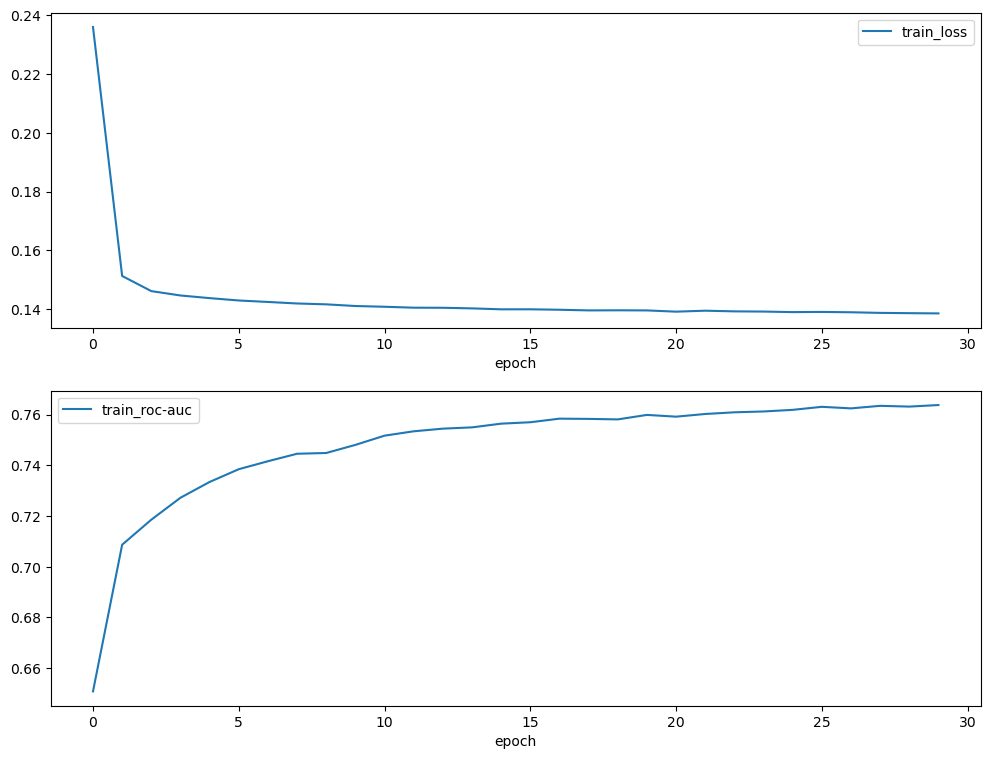

In [25]:
def plot_trainig(losses, metrics):
    plt.figure(figsize=(12, 9))
    plt.subplot(2, 1, 1)
    plt.xlabel("epoch")
    plt.plot(losses, label="train_loss")
    plt.legend()
    
    plt.subplot(2, 1, 2)
    plt.xlabel("epoch")
    plt.plot(metrics, label="train_roc-auc")
    plt.legend()

plot_trainig(losses, metrics)

#### with Elu|

In [17]:
from tqdm.auto import tqdm

X_train, X_test, y_train, y_test = train_test_split(df[df.columns[:-1]], df['target'], stratify=df['target'], train_size=0.7, random_state=1)

scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)

X_train_t =  torch.FloatTensor(X_train.values)
y_train_t =  torch.FloatTensor(y_train.values).view(-1, 1)
X_test_t =  torch.FloatTensor(X_test.values)
y_test_t =  torch.FloatTensor(y_test.values).view(-1, 1)

train_loader = torch.utils.data.DataLoader(list(zip(X_train_t, y_train_t)), batch_size=10000, shuffle=True)
test_loader = torch.utils.data.DataLoader(list(zip(X_test_t, y_test_t)), batch_size=10000, shuffle=False)

import torch.nn.functional as F
    
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()        
        self.fc1 = nn.Linear(194, 100, bias=True)
        self.fc2 = nn.Linear(100, 50, bias=True)
        self.dropout = nn.Dropout(p=0.4)
        self.fc3 = nn.Linear(50, 20, bias=True)
        self.fc4 = nn.Linear(20, 5, bias=True)
        self.fc5 = nn.Linear(5, 1, bias=True)
        
    def forward(self, x):
        x = F.elu(self.fc1(x))
        x = self.dropout(F.relu(self.fc2(x)))
        x = F.elu(self.fc3(x))
        x = F.elu(self.fc4(x))
        x = F.sigmoid(self.fc5(x))
        return x

nn_model = Net()

def train_stochastic(model, loader, criterion, optimazer, num_epoch, X_train_t, y_train_t):
    
    losses = []
    roc_auc_metrics = []
    for t in tqdm(range(num_epoch)):
        epoch_loss = []
        metrics = []
        for X_batch, y_batch in loader:
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            epoch_loss.append(loss.item())

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
                     
        losses.append(np.mean(epoch_loss))
        print("curr_loss", np.mean(epoch_loss))
        
        with torch.no_grad():
            nn_prediction_train = model(X_train_t).tolist()
            roc_auc_metrics.append(roc_auc_score(y_train_t, nn_prediction_train))
            print('train: ', roc_auc_score(y_train_t, nn_prediction_train))

    return model, losses, roc_auc_metrics
    
loss = torch.nn.BCELoss()
optimizer = torch.optim.Adam(nn_model.parameters(), lr=1e-3)
#optimizer = torch.optim.SGD(nn_model.parameters(), lr=1e-3, momentum=0.9)

model, losses, metrics = train_stochastic(nn_model, train_loader, loss, optimizer, 30, X_train_t, y_train_t)

with torch.no_grad():
    nn_prediction_train = model(X_train_t)
    nn_prediction_train = nn_prediction_train.tolist() 
    
    nn_prediction_test = model(X_test_t)
    nn_prediction_test = nn_prediction_test.tolist()

    print('train: ', roc_auc_score(y_train, nn_prediction_train))
    print('test: ', roc_auc_score(y_test, nn_prediction_test))

  0%|          | 0/30 [00:00<?, ?it/s]

curr_loss 0.20725272425371616
train:  0.5853241595168402
curr_loss 0.14964283980540374
train:  0.7053703824175186
curr_loss 0.14452455315127302
train:  0.7267819797173181
curr_loss 0.14299860559589234
train:  0.7355550818979815
curr_loss 0.1422671944792591
train:  0.7401445370869421
curr_loss 0.1417988324491539
train:  0.7425750372918815
curr_loss 0.14176862445933308
train:  0.744297770226402
curr_loss 0.14149810496106077
train:  0.7466402951993637
curr_loss 0.14127213470823136
train:  0.7484027328135977
curr_loss 0.14114504904296268
train:  0.748767237877688
curr_loss 0.1407912692323846
train:  0.7505554796956522
curr_loss 0.14061302339556206
train:  0.7509905697288497
curr_loss 0.14046922600387934
train:  0.7520235828743655
curr_loss 0.14036011614313174
train:  0.7529818906469514
curr_loss 0.14020013390340616
train:  0.7543501213043626
curr_loss 0.14006019461510785
train:  0.7549502494902925
curr_loss 0.13983309569198693
train:  0.7551907485964986
curr_loss 0.14004789982269059
train:

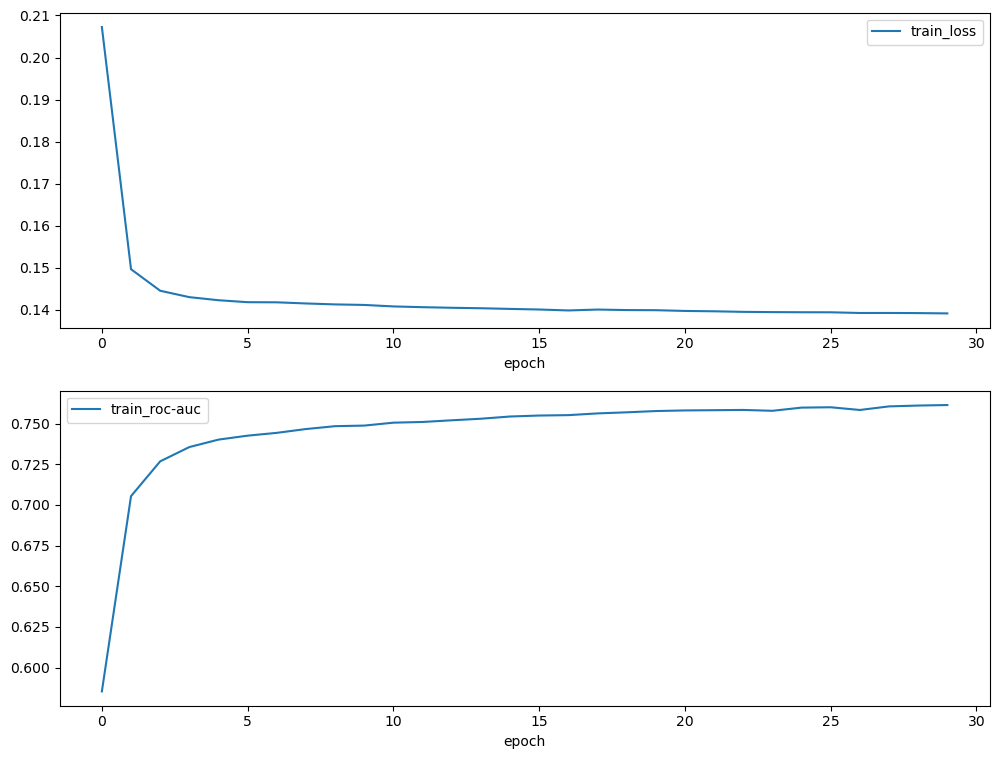

In [19]:
plot_trainig(losses, metrics)

#### With sampler

In [57]:
from collections import Counter
from torch.utils.data.sampler import WeightedRandomSampler

X_train, X_test, y_train, y_test = train_test_split(df[df.columns[:-1]], df['target'], stratify=df['target'], train_size=0.7)

scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)

X_train_t =  torch.FloatTensor(X_train.values)
y_train_t =  torch.FloatTensor(y_train.values).view(-1, 1)
X_test_t =  torch.FloatTensor(X_test.values)
y_test_t =  torch.FloatTensor(y_test.values).view(-1, 1)

counter = Counter(i.item() for i, in y_train_t)
weights = [1/counter.get(i.item()) for i, in y_train_t]
sampler = WeightedRandomSampler(weights, num_samples=len(weights))

train_loader = torch.utils.data.DataLoader(list(zip(X_train_t, y_train_t)), batch_size=10000, sampler=sampler)
test_loader = torch.utils.data.DataLoader(list(zip(X_test_t, y_test_t)), batch_size=10000, shuffle=False)

import torch.nn.functional as F
    
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()        
        self.fc1 = nn.Linear(194, 100, bias=True)
        self.fc2 = nn.Linear(100, 50, bias=True)
        self.dropout = nn.Dropout(p=0.4)
        self.fc3 = nn.Linear(50, 20, bias=True)
        self.fc4 = nn.Linear(20, 5, bias=True)
        self.fc5 = nn.Linear(5, 1, bias=True)
        
    def forward(self, x):
        x = F.leaky_relu(self.fc1(x))
        x = self.dropout(F.relu(self.fc2(x)))
        x = F.leaky_relu(self.fc3(x))
        x = F.leaky_relu(self.fc4(x))
        x = F.sigmoid(self.fc5(x))
        return x

nn_model = Net()

def train_stochastic(model, loader, criterion, optimazer, num_epoch, X_train_t, y_train_t):
    
    losses = []
    roc_auc_metrics = []
    for t in tqdm(range(num_epoch)):
        epoch_loss = []
        metrics = []
        for X_batch, y_batch in loader:
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            epoch_loss.append(loss.item())

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
                     
        losses.append(np.mean(epoch_loss))
        print("curr_loss", np.mean(epoch_loss))
        
        with torch.no_grad():
            nn_prediction_train = model(X_train_t).tolist()
            roc_auc_metrics.append(roc_auc_score(y_train_t, nn_prediction_train))
            print('train: ', roc_auc_score(y_train_t, nn_prediction_train))

    return model, losses, roc_auc_metrics
    
loss = torch.nn.BCELoss()
optimizer = torch.optim.Adam(nn_model.parameters(), lr=1e-3)

model, losses, metrics = train_stochastic(nn_model, train_loader, loss, optimizer, 15, X_train_t, y_train_t)

with torch.no_grad():
    nn_prediction_train = model(X_train_t)
    nn_prediction_train = nn_prediction_train.tolist() 
    
    nn_prediction_test = model(X_test_t)
    nn_prediction_test = nn_prediction_test.tolist()

    print('train: ', roc_auc_score(y_train, nn_prediction_train))
    print('test: ', roc_auc_score(y_test, nn_prediction_test))

  0%|          | 0/15 [00:00<?, ?it/s]

curr_loss 0.6261395147783839
train:  0.7461130751142657
curr_loss 0.5893325449815437
train:  0.7556742115033024
curr_loss 0.5846785407754319
train:  0.759589443777575
curr_loss 0.5820759955923356
train:  0.7631409501231562
curr_loss 0.578950027624766
train:  0.7651774079498652
curr_loss 0.5760291064556559
train:  0.768361973969754
curr_loss 0.5728049942510045
train:  0.7703245436397607
curr_loss 0.5712140531682256
train:  0.7716228418794708
curr_loss 0.5699308903063115
train:  0.7748508450319875
curr_loss 0.567281778772079
train:  0.7767721408399372
curr_loss 0.5656014986299164
train:  0.7770813838460681
curr_loss 0.5626751116259181
train:  0.7794165005943171
curr_loss 0.5603623301235597
train:  0.7798651930605667
curr_loss 0.5590115032385831
train:  0.7821612745849612
curr_loss 0.5576398660294453
train:  0.7840197429473298
train:  0.784048614441595
test:  0.7434524943750535


#### with SMOTE

In [76]:
from imblearn.over_sampling import SMOTE


X_train, X_test, y_train, y_test = train_test_split(df[df.columns[:-1]], df['target'], stratify=df['target'], train_size=0.7)

os = SMOTE(k_neighbors=4)
X_train_2, y_train_2 = os.fit_resample(X_train, y_train)

scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)

X_train_t =  torch.FloatTensor(X_train_2.values)
y_train_t =  torch.FloatTensor(y_train_2.values).view(-1, 1)
X_test_t =  torch.FloatTensor(X_test.values)
y_test_t =  torch.FloatTensor(y_test.values).view(-1, 1)


train_loader = torch.utils.data.DataLoader(list(zip(X_train_t, y_train_t)), batch_size=10000, shuffle=True, drop_last=False)
test_loader = torch.utils.data.DataLoader(list(zip(X_test_t, y_test_t)), batch_size=10000, shuffle=False, drop_last=False)

In [77]:
import torch.nn.functional as F
    
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()        
        self.fc1 = nn.Linear(194, 100, bias=True)
        self.fc2 = nn.Linear(100, 50, bias=True)
        self.dropout = nn.Dropout(p=0.4)
        self.fc3 = nn.Linear(50, 20, bias=True)
        self.fc4 = nn.Linear(20, 5, bias=True)
        self.fc5 = nn.Linear(5, 1, bias=True)
        
    def forward(self, x):
        x = F.leaky_relu(self.fc1(x))
        x = self.dropout(F.relu(self.fc2(x)))
        x = F.leaky_relu(self.fc3(x))
        x = F.leaky_relu(self.fc4(x))
        x = F.sigmoid(self.fc5(x))
        return x

nn_model = Net()

def train_stochastic(model, loader, criterion, optimazer, num_epoch, X_train_t, y_train_t):
    
    losses = []
    roc_auc_metrics = []
    for t in tqdm(range(num_epoch)):
        epoch_loss = []
        metrics = []
        for X_batch, y_batch in loader:
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            epoch_loss.append(loss.item())

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
                     
        losses.append(np.mean(epoch_loss))
        print("curr_loss", np.mean(epoch_loss))
        
        with torch.no_grad():
            nn_prediction_train = model(X_train_t).tolist()
            roc_auc_metrics.append(roc_auc_score(y_train_t, nn_prediction_train))
            print('train: ', roc_auc_score(y_train_t, nn_prediction_train))

    return model, losses, roc_auc_metrics
    
loss = torch.nn.BCELoss()
optimizer = torch.optim.Adam(nn_model.parameters(), lr=1e-3)

model, losses, metrics = train_stochastic(nn_model, train_loader, loss, optimizer, 15, X_train_t, y_train_t)

with torch.no_grad():
    nn_prediction_train = model(X_train_t)
    nn_prediction_train = nn_prediction_train.tolist() 
    
    nn_prediction_test = model(X_test_t)
    nn_prediction_test = nn_prediction_test.tolist()

    print('train: ', roc_auc_score(y_train_t, nn_prediction_train))
    print('test: ', roc_auc_score(y_test, nn_prediction_test))

  0%|          | 0/15 [00:00<?, ?it/s]

curr_loss 0.18588580737382637
train:  0.9859615008083138
curr_loss 0.10496606660398794
train:  0.9873833468907136
curr_loss 0.10141070694735013
train:  0.9879147533370098
curr_loss 0.09942607012205791
train:  0.9880549809861758
curr_loss 0.09811511888636826
train:  0.9884078885462964
curr_loss 0.09705086202973529
train:  0.9884366564742613
curr_loss 0.09638362457020296
train:  0.9886910615271381
curr_loss 0.0954420953178344
train:  0.988699184605543
curr_loss 0.09439403619713733
train:  0.9887138009240545
curr_loss 0.09404045393584305
train:  0.9889618874597673
curr_loss 0.09332302158669487
train:  0.989074011020953
curr_loss 0.09308623514799257
train:  0.989155689801351
curr_loss 0.09225401382681002
train:  0.9892605796047501
curr_loss 0.09227653563871903
train:  0.9891110219675068
curr_loss 0.0917129758841942
train:  0.9892841857956931
train:  0.9892759631494056
test:  0.7370575638135158


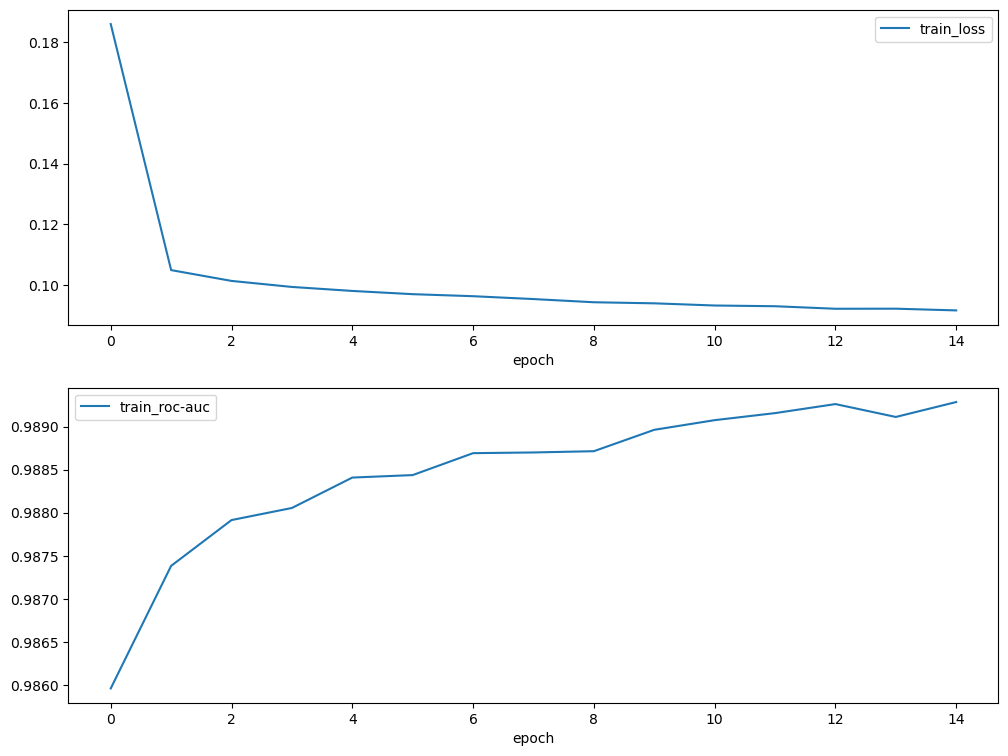

In [78]:
plot_trainig(losses, metrics)

### Ensamble with best RELU model (+dropout)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(df[df.columns[:-1]], df['target'], stratify=df['target'], train_size=0.7)

scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)

X_train_t =  torch.FloatTensor(X_train.values)
y_train_t =  torch.FloatTensor(y_train.values).view(-1, 1)
X_test_t =  torch.FloatTensor(X_test.values)
y_test_t =  torch.FloatTensor(y_test.values).view(-1, 1)

X_train_nump = X_train.to_numpy()
y_train_nump =  y_train.to_numpy()
X_test_nump =  X_test.to_numpy()
y_test_nump =  y_test.to_numpy()

class Net_model(nn.Module):
    def __init__(self):
        super(Net_model, self).__init__()  
        self.fc1 = nn.Linear(194, 100, bias=True)
        self.fc2 = nn.Linear(100, 50, bias=True)
        self.dropout = nn.Dropout(p=0.4)
        self.fc3 = nn.Linear(50, 20, bias=True)
        self.fc4 = nn.Linear(20, 5, bias=True)
        self.fc5 = nn.Linear(5, 1, bias=True)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(F.relu(self.fc2(x)))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.sigmoid(self.fc5(x))
        return x
        
net = Net_model()

class PytorchModel(sklearn.base.BaseEstimator):
    def __init__(self, net_type, net_params, optimizer_type, optimizer_params, loss_fn,
               batch_size=10000, auc_tol=0.04, tol_epochs=10):
        self.net_type = net_type
        self.net_params = net_params
        self.optimizer_type = optimizer_type
        self.optimizer_params = optimizer_params
        self.loss_fn = loss_fn

        self.batch_size = batch_size
        self.auc_tol = auc_tol 
        self.tol_epochs = tol_epochs

    
    def fit(self, X, y):
        super().__init__()
        self.net = self.net_type(**self.net_params)
        self.optimizer = self.optimizer_type(self.net.parameters(), **self.optimizer_params)
        
        uniq_classes = np.sort(np.unique(y))
        self.classes_ = uniq_classes
    
        X_t = torch.FloatTensor(X)
        y_t = torch.FloatTensor(y).view(-1, 1)
        train_dataset = TensorDataset(X_t, y_t)
        train_loader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True, drop_last=False)
        metrics = []
        epoch = 0
        keep_training = True   
        while keep_training:
            self.net.train()
            epoch_loss = []

            for X_batch, y_batch in train_loader:
                y_pred = self.net(X_batch)
                loss = self.loss_fn(y_pred, y_batch)
                epoch_loss.append(loss.item())
                
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()               
            print("curr_loss", np.mean(epoch_loss))
            with torch.no_grad():
                nn_prediction_train = self.net(X_t).tolist()
                roc_auc_sc = roc_auc_score(y_t, nn_prediction_train)
                print('train: ', roc_auc_score(y_t, nn_prediction_train))
                metrics.append(roc_auc_sc)
                
            if len(metrics) > self.tol_epochs:
                metrics.pop(0)
            if len(metrics) == self.tol_epochs:
                roc_auc_diff = max(metrics) - min(metrics)
                if roc_auc_diff <= self.auc_tol:
                    print('-----------------------------------------------------------------------------------------')
                    keep_training = False
    

    def predict_proba(self, X):
        X_tensor = torch.tensor(X.astype(np.float32))
        self.net.eval()
        preds_proba = self.net(X_tensor).detach().numpy()
        return preds_proba

    def predict(self, X):
        preds_proba = self.predict_proba(X)
        predictions = np.amax(predictions, axis=1)
        return predictions

In [10]:
def get_pred(predictions):
    predictions = np.amax(predictions, axis=1)
    return predictions

In [9]:
base_model = PytorchModel(net_type=Net_model, net_params=dict(), optimizer_type=Adam,
                          optimizer_params={"lr": 1e-3}, loss_fn=torch.nn.BCELoss(),
                          batch_size=10000, auc_tol=0.003, tol_epochs=10)

meta_classifier = BaggingClassifier(estimator=base_model, n_estimators=10)
meta_classifier.fit(X_train, y_train)

curr_loss 0.20490523312815387
train:  0.6500348038281465
curr_loss 0.15001269574485607
train:  0.7113328796444929
curr_loss 0.14520823162289995
train:  0.724146813570458
curr_loss 0.14348693340275417
train:  0.7325087481859762
curr_loss 0.1426303187264732
train:  0.7381164592895236
curr_loss 0.14194670389985564
train:  0.7429805433149134
curr_loss 0.1413740165049757
train:  0.7447568774055168
curr_loss 0.14082292133747643
train:  0.751394389321732
curr_loss 0.14031384581357093
train:  0.7538891590298382
curr_loss 0.13969195207849663
train:  0.7578323201673329
curr_loss 0.13900843314567016
train:  0.7602754773522206
curr_loss 0.13881815006187306
train:  0.7629383350848101
curr_loss 0.13838796480674648
train:  0.7663456646568453
curr_loss 0.1380709820422367
train:  0.7665710123429721
curr_loss 0.13769617105894422
train:  0.7701457622902853
curr_loss 0.13728609466137578
train:  0.7683728126928824
curr_loss 0.1372589359977352
train:  0.7736943185266442
curr_loss 0.1370307042156879
train:  

BaggingClassifier(estimator=PytorchModel(auc_tol=0.005, loss_fn=BCELoss(),
                                         net_params={},
                                         net_type=<class '__main__.Net_model'>,
                                         optimizer_params={'lr': 0.001},
                                         optimizer_type=<class 'torch.optim.adam.Adam'>))

In [12]:
pred = meta_classifier.predict_proba(X_test)
pred_2 = get_pred(pred)

In [16]:
roc_auc_score(y_test, pred_2)

0.7574447479170181

### Ensamble with best RELU model (without dropout)

In [33]:
X_train, X_test, y_train, y_test = train_test_split(df[df.columns[:-1]], df['target'], stratify=df['target'], train_size=0.7)

scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)

X_train_t =  torch.FloatTensor(X_train.values)
y_train_t =  torch.FloatTensor(y_train.values).view(-1, 1)
X_test_t =  torch.FloatTensor(X_test.values)
y_test_t =  torch.FloatTensor(y_test.values).view(-1, 1)

X_train_nump = X_train.to_numpy()
y_train_nump =  y_train.to_numpy()
X_test_nump =  X_test.to_numpy()
y_test_nump =  y_test.to_numpy()

class Net_model(nn.Module):
    def __init__(self):
        super(Net_model, self).__init__()  
        self.fc1 = nn.Linear(194, 100, bias=True)
        self.fc2 = nn.Linear(100, 50, bias=True)
        self.fc3 = nn.Linear(50, 20, bias=True)
        self.fc4 = nn.Linear(20, 5, bias=True)
        self.fc5 = nn.Linear(5, 1, bias=True)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.sigmoid(self.fc5(x))
        return x
        
net = Net_model()

class PytorchModel(sklearn.base.BaseEstimator):
    def __init__(self, net_type, net_params, optimizer_type, optimizer_params, loss_fn,
               batch_size=10000, auc_tol=0.04, tol_epochs=10):
        self.net_type = net_type
        self.net_params = net_params
        self.optimizer_type = optimizer_type
        self.optimizer_params = optimizer_params
        self.loss_fn = loss_fn

        self.batch_size = batch_size
        self.auc_tol = auc_tol 
        self.tol_epochs = tol_epochs

    
    def fit(self, X, y):
        super().__init__()
        self.net = self.net_type(**self.net_params)
        self.optimizer = self.optimizer_type(self.net.parameters(), **self.optimizer_params)
        
        uniq_classes = np.sort(np.unique(y))
        self.classes_ = uniq_classes
    
        X_t = torch.FloatTensor(X)
        y_t = torch.FloatTensor(y).view(-1, 1)
        train_dataset = TensorDataset(X_t, y_t)
        train_loader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True, drop_last=False)
        metrics = []
        epoch = 0
        keep_training = True   
        while keep_training:
            self.net.train()
            epoch_loss = []

            for X_batch, y_batch in train_loader:
                y_pred = self.net(X_batch)
                loss = self.loss_fn(y_pred, y_batch)
                epoch_loss.append(loss.item())
                
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()               
            print("curr_loss", np.mean(epoch_loss))
            with torch.no_grad():
                nn_prediction_train = self.net(X_t).tolist()
                roc_auc_sc = roc_auc_score(y_t, nn_prediction_train)
                print('train: ', roc_auc_score(y_t, nn_prediction_train))
                metrics.append(roc_auc_sc)
                
            if len(metrics) > self.tol_epochs:
                metrics.pop(0)
            if len(metrics) == self.tol_epochs:
                roc_auc_diff = max(metrics) - min(metrics)
                if roc_auc_diff <= self.auc_tol:
                    print('-----------------------------------------------------------------------------------------')
                    keep_training = False
    

    def predict_proba(self, X):
        X_tensor = torch.tensor(X.astype(np.float32))
        self.net.eval()
        preds_proba = self.net(X_tensor).detach().numpy()
        return preds_proba

    def predict(self, X):
        preds_proba = self.predict_proba(X)
        predictions = np.amax(predictions, axis=1)
        return predictions

In [34]:
def get_pred(predictions):
    predictions = np.amax(predictions, axis=1)
    return predictions

In [35]:
base_model_nodrop = PytorchModel(net_type=Net_model, net_params=dict(), optimizer_type=Adam,
                          optimizer_params={"lr": 1e-3}, loss_fn=torch.nn.BCELoss(),
                          batch_size=10000, auc_tol=0.005, tol_epochs=10)

meta_classifier_nodrop = BaggingClassifier(estimator=base_model_nodrop, n_estimators=5)
meta_classifier_nodrop.fit(X_train, y_train)

curr_loss 0.23042401701063658
train:  0.702924246773754
curr_loss 0.1448930241723559
train:  0.7364370538922558
curr_loss 0.14236768835516117
train:  0.7464012499631537
curr_loss 0.14132727052441876
train:  0.752195106375956
curr_loss 0.14093855653532703
train:  0.754829566371274
curr_loss 0.1404608132604936
train:  0.7589541116803166
curr_loss 0.1398800436537064
train:  0.7603154277967308
curr_loss 0.1398379325644294
train:  0.758734163409503
curr_loss 0.1393679123909319
train:  0.7630489409548029
curr_loss 0.13896753805786816
train:  0.7642064627761472
curr_loss 0.13880301467073497
train:  0.7648764546180308
curr_loss 0.13854043259846038
train:  0.7682798487715515
curr_loss 0.13843151167109238
train:  0.7648497109911425
curr_loss 0.13828840421799996
train:  0.7698752161956878
curr_loss 0.13797582912059567
train:  0.7708837272929068
curr_loss 0.13782793772754384
train:  0.771477978980317
curr_loss 0.1376117870063331
train:  0.7711683430482029
curr_loss 0.13762096853102024
train:  0.77

BaggingClassifier(estimator=PytorchModel(auc_tol=0.005, loss_fn=BCELoss(),
                                         net_params={},
                                         net_type=<class '__main__.Net_model'>,
                                         optimizer_params={'lr': 0.001},
                                         optimizer_type=<class 'torch.optim.adam.Adam'>),
                  n_estimators=5)

In [36]:
pred_nodrop = meta_classifier_nodrop.predict_proba(X_test)
pred_2_nodrop = get_pred(pred_nodrop)

In [37]:
roc_auc_score(y_test, pred_2_nodrop)

0.752063258712846